In [7]:
import warnings
warnings.filterwarnings("ignore")
import numpy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
import os
import unicodedata
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
import seaborn as sns
import scipy.stats as stats
sns.set(font_scale=1)
sns.set_style("white")
sns.set_style("ticks")
import plotly.express as px
from geopy.geocoders import Nominatim
import unicodedata
import time
from tqdm import tqdm
import re
from googletrans import Translator

translator = Translator()

# User recommendation data

In [8]:
data_dir = '../data/確定2024.01.普通mansionfit.03-02-01_おすすめ物件と閲覧数.xlsx'
df = pd.read_excel(data_dir)
df.columns = [unicodedata.normalize('NFKC', s) for s in df.columns]
df.columns = [s+'\n'+str(translator.translate(s, dest='en').text) for s in df.columns]

pr = []
for i in df['推論_価格\nPrint _ Price']:
    try:
        pr.append(eval(i)['prediction'])
    except:
        pr.append(-1)
df['price_predicted'] = pr

print(df.shape)
df.head()

(12505, 35)


,ユーザID\nUser ID,物件種類\nProperty type,属性ID\nAttribute ID,診断\ndiagnosis,LINE登録日\nLINE registration date,診断日時\nDiagnosis date and time,物件紹介日時\nProperty introduction date and time,家族構成\nFamily composition,年代\nEra,居住地沿線\nAlong the place of residence,居住地最寄駅\nNearest station,勤務先沿線\nAlong the workplace,勤務先最寄駅\nClose station to work,世帯年収\nhousehold income,家賃\nrent,診断_価格\nDiagnosis_ Price,診断_広さ\nDiagnosis_,診断_エリア\nDiagnosis _ area,推論_エリア\nProgress_ Area,タイプ\ntype,物件ID\nProperty ID,物件名\nObject name,物件概要閲覧\nProperty Overview view,MR閲覧\nMR viewing,予約表示\nReservation display,資料請求表示\nData request representation,予約数\nNumber of reservations,予約+資料請求数\nReservation+number of requests requested,資料請求数\nData request number,予約キャンセル数\nNumber of reserved cancellations,推論_価格\nPrint _ Price,推論_スコア\nProgress_ Score,推論_クラスター\nProgress_Cluster,前回リマインド日時\nLast time remind date and time,price_predicted
0,4,MF,17361,リマインド,2020-03-30 08:55:00,2021-10-15 10:37:00,2024-01-05 19:01:00,パートナーと子供,35,JR東海道本線(東京～熱海),横浜,JR山手線,東京,1000,120000,51776250,72.95,東京東,東京23区東エリア,物件概要閲覧,81,ローレルスクエア湘南平塚,0,0,0,0,0,0,0,0,"{""error"": 5197224, ""prediction"": 43298628}","{""error"": {""price_score"": 0.2586548238, ""famil...","{""type"": 4, ""preferences"": [""spaciosity_score""...",2024-02-02 19:01:00,43298628
1,6,MF,27860,リマインド,2020-04-02 08:18:00,2022-11-23 23:56:00,2024-01-05 19:03:00,パートナー,45,JR横須賀線,東戸塚,JR山手線,代々木,1500,200000,52900000,71.36,神奈川,神奈川東エリア,予約画面閲覧,125,サンリヤン東戸塚,0,0,0,0,0,0,0,0,"{""error"": 5197224, ""prediction"": 49362360}","{""error"": {""price_score"": 0.2586548238, ""famil...","{""type"": 2, ""preferences"": [""environment_score...",2024-01-05 19:03:00,49362360
2,7,MF,27765,リマインド,2020-04-02 08:21:00,2022-11-17 16:44:00,2024-01-05 19:01:00,パートナーと子供,45,JR中央線(快速),国分寺,東京メトロ丸ノ内線,赤坂見附,1500,160000,59380200,73.92,神奈川,東京23区東エリア,物件概要閲覧,238,ルネ花小金井ザ・レジデンス,0,0,0,0,0,0,0,0,"{""error"": 5197224, ""prediction"": 46935804}","{""error"": {""price_score"": 0.2586548238, ""famil...","{""type"": 2, ""preferences"": [""environment_score...",2024-02-02 19:03:00,46935804
3,7,MF,27765,新着物件,2020-04-02 08:21:00,2022-11-17 16:44:00,2024-01-18 19:04:00,パートナーと子供,45,JR中央線(快速),国分寺,東京メトロ丸ノ内線,赤坂見附,1500,160000,59380200,73.92,神奈川,東京23区東エリア,新着物件レコメンド,260,【新築分譲戸建】グローイングスクエア花小金井,0,0,0,0,0,0,0,0,"{""error"": 5197224, ""prediction"": 46935804}","{""error"": {""price_score"": 0.2586548238, ""famil...","{""type"": 2, ""preferences"": [""environment_score...",2024-02-02 19:03:00,46935804
4,7,MF,27765,新着物件,2020-04-02 08:21:00,2022-11-17 16:44:00,2024-01-25 19:02:00,パートナーと子供,45,JR中央線(快速),国分寺,東京メトロ丸ノ内線,赤坂見附,1500,160000,59380200,73.92,神奈川,東京23区東エリア,新着物件レコメンド,260,【新築分譲戸建】グローイングスクエア花小金井,0,0,0,0,0,0,0,0,"{""error"": 5197224, ""prediction"": 46935804}","{""error"": {""price_score"": 0.2586548238, ""famil...","{""type"": 2, ""preferences"": [""environment_score...",2024-02-02 19:03:00,46935804


In [9]:
# Find recommendation
good_reco = df[df['世帯年収\nhousehold income']>=800]
good_reco = good_reco[good_reco['世帯年収\nhousehold income']<=1200]
print(good_reco.shape)
good_reco = good_reco[good_reco['price_predicted']>=40000000]
good_reco = good_reco[good_reco['price_predicted']<=50000000]
print(good_reco.shape)
good_reco = good_reco[good_reco['家族構成\nFamily composition']=='パートナーと子供']
print(good_reco.shape)
good_reco = good_reco[good_reco['診断_広さ\nDiagnosis_']>=45]
print(good_reco.shape)

(4947, 35)
(2825, 35)
(1443, 35)
(1443, 35)


In [10]:
df_new = df[df['診断\ndiagnosis'].isin(['新着物件', '新着物件', '診断'])]
df_booked = df_new[df_new['予約数\nNumber of reservations']==1]

print(df_booked.shape)
print(df_new.shape)
df_new.head()

(16, 35)
(5691, 35)


,ユーザID\nUser ID,物件種類\nProperty type,属性ID\nAttribute ID,診断\ndiagnosis,LINE登録日\nLINE registration date,診断日時\nDiagnosis date and time,物件紹介日時\nProperty introduction date and time,家族構成\nFamily composition,年代\nEra,居住地沿線\nAlong the place of residence,居住地最寄駅\nNearest station,勤務先沿線\nAlong the workplace,勤務先最寄駅\nClose station to work,世帯年収\nhousehold income,家賃\nrent,診断_価格\nDiagnosis_ Price,診断_広さ\nDiagnosis_,診断_エリア\nDiagnosis _ area,推論_エリア\nProgress_ Area,タイプ\ntype,物件ID\nProperty ID,物件名\nObject name,物件概要閲覧\nProperty Overview view,MR閲覧\nMR viewing,予約表示\nReservation display,資料請求表示\nData request representation,予約数\nNumber of reservations,予約+資料請求数\nReservation+number of requests requested,資料請求数\nData request number,予約キャンセル数\nNumber of reserved cancellations,推論_価格\nPrint _ Price,推論_スコア\nProgress_ Score,推論_クラスター\nProgress_Cluster,前回リマインド日時\nLast time remind date and time,price_predicted
3,7,MF,27765,新着物件,2020-04-02 08:21:00,2022-11-17 16:44:00,2024-01-18 19:04:00,パートナーと子供,45,JR中央線(快速),国分寺,東京メトロ丸ノ内線,赤坂見附,1500,160000,59380200,73.92,神奈川,東京23区東エリア,新着物件レコメンド,260,【新築分譲戸建】グローイングスクエア花小金井,0,0,0,0,0,0,0,0,"{""error"": 5197224, ""prediction"": 46935804}","{""error"": {""price_score"": 0.2586548238, ""famil...","{""type"": 2, ""preferences"": [""environment_score...",2024-02-02 19:03:00,46935804
4,7,MF,27765,新着物件,2020-04-02 08:21:00,2022-11-17 16:44:00,2024-01-25 19:02:00,パートナーと子供,45,JR中央線(快速),国分寺,東京メトロ丸ノ内線,赤坂見附,1500,160000,59380200,73.92,神奈川,東京23区東エリア,新着物件レコメンド,260,【新築分譲戸建】グローイングスクエア花小金井,0,0,0,0,0,0,0,0,"{""error"": 5197224, ""prediction"": 46935804}","{""error"": {""price_score"": 0.2586548238, ""famil...","{""type"": 2, ""preferences"": [""environment_score...",2024-02-02 19:03:00,46935804
9,34,MF,24076,新着物件,2020-04-03 19:43:00,2022-06-25 05:33:00,2024-01-18 19:03:00,パートナー,35,京急本線,金沢文庫,都営浅草線,三田,1500,120000,58806000,72.21,神奈川,神奈川東エリア,新着物件レコメンド,261,ガーデングランデ横浜戸塚,0,0,0,0,0,0,0,0,"{""error"": 5197224, ""prediction"": 45118528}","{""error"": {""price_score"": 0.2586548238, ""famil...","{""type"": 2, ""preferences"": [""environment_score...",2024-02-02 19:01:00,45118528
10,34,MF,24076,新着物件,2020-04-03 19:43:00,2022-06-25 05:33:00,2024-01-25 19:04:00,パートナー,35,京急本線,金沢文庫,都営浅草線,三田,1500,120000,58806000,72.21,神奈川,神奈川東エリア,新着物件レコメンド,261,ガーデングランデ横浜戸塚,0,0,0,0,0,0,0,0,"{""error"": 5197224, ""prediction"": 45118528}","{""error"": {""price_score"": 0.2586548238, ""famil...","{""type"": 2, ""preferences"": [""environment_score...",2024-02-02 19:01:00,45118528
42,473,MF,25386,新着物件,2020-07-20 21:37:00,2022-08-20 10:32:00,2024-01-25 19:03:00,パートナー,25,東京メトロ南北線,麻布十番,東京メトロ銀座線,新橋,1000,200000,49200000,70.21,東京東,東京23区中央エリア,新着物件レコメンド,262,ザ・ライオンズ武蔵小杉,0,0,0,0,0,0,0,0,"{""error"": 5197224, ""prediction"": 72893448}","{""error"": {""price_score"": 0.2586548238, ""famil...","{""type"": 3, ""preferences"": [""spaciosity_score""...",2024-02-02 19:01:00,72893448


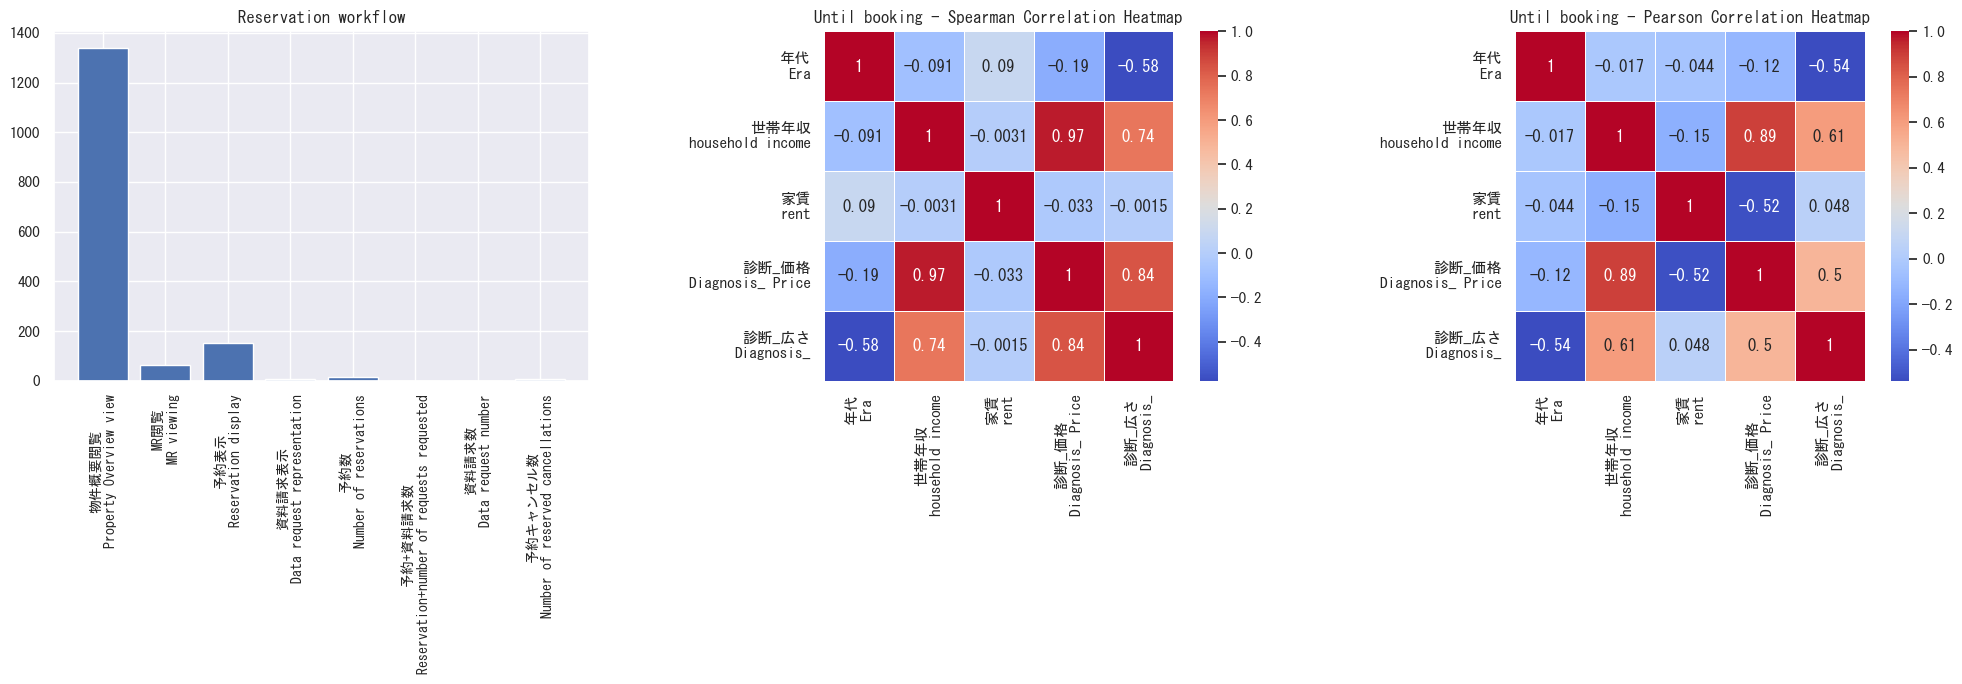

In [11]:
sns.set_style("white")
sns.set(font_scale=1.0, font="MS Gothic")
data = df_new.iloc[:,[22,23,24,25,26,27,28,29]].sum().to_numpy()
label = list(df_new.iloc[:,[22,23,24,25,26,27,28,29]].columns)

col = [8,13,14,15,16]
spearman_corr = df_booked.iloc[:,col].corr(method='spearman')
pearson_corr = df_booked.iloc[:,col].corr(method='pearson')

plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.bar(range(len(data)), data)
plt.xticks(range(len(data)), label, fontsize=10, fontname="MS Gothic", rotation=90)
plt.title('Reservation workflow')
plt.subplot(1,3,2)
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', square=True, linewidths=.5)
plt.title('Until booking - Spearman Correlation Heatmap')
plt.subplot(1,3,3)
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', square=True, linewidths=.5)
plt.title('Until booking - Pearson Correlation Heatmap')
plt.tight_layout()
plt.show()

In [12]:
# address = 'さいたま市浦和区 上木崎 1-9-17'
# result = gmaps.geocode(address)